## This example benefits from running on a GPU! 
Though it is not strictly necessary. Only recommended.

- Here we illustrate using linear perturbation theory to simulate the effects of varying the (a) mass of subhalos and (b) the scale-radius of subhalos impacting a stream. 

- After an initial computation, variations to the mass and radius of a subhalo are comptued _algebraically_, without the need for any additional simulation. This means that we can adust the mass of a subhalo as a post-processing step. In fact, we can even remove subhalos entirely by setting their mass to zero.

- This enables us to generate 1000s of impacts as a pre-processing step, and sample different combinations of subhalo masses and scale-radii algebraically. 

The math follows a taylor expansion:
$$ \rm{stream}(M_{\rm sh}, \Delta r_{s}) = \rm{stream_{0}} + \sum_{M_{\rm sh}, r_s} \left[ \frac{d\rm{stream}}{dM_{\rm sh}}
    + \frac{d^2 stream}{dM_{\rm sh} dr_s} M_{\rm sh} \Delta r_s + \mathcal{O}\left(M_{\rm sh}^2\right)\right]$$


- Here we will compute the derivatives for a GD-1 like stream with 50 subhalo impacts. For production runs, one can generate batches of these derivatives (preferably on a GPU for massive speedup). Several thousand derivatives can be obtained in 10s of minutes on a A100 gpu.

- For illustration purposes, we will then focus on one subhalo and visualize how one can sample its mass and radius spectrum, and generate the stream's response.



In [ ]:
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np

from streamsculptor import potential
from streamsculptor import JaxCoords as jc
import diffrax



In [2]:
## Estimated progenitor location today in [kpc, kpc, kpc, kpc/Myr, kpc/Myr, kpc/Myr]
## Estimated in a seperate file, but will provide a good starting point for this notebook
## This file can be found in the data folder of the streamsculptor repository:
## data/GD1_prog/GD1_progenitor.npy
prog_wtoday = jnp.load('../data/GD1_prog/GD1_progenitor.npy',allow_pickle=True).item()
pos = prog_wtoday.pos.xyz.to(u.kpc).value
vel = prog_wtoday.vel.d_xyz.to(u.kpc/u.Myr).value
prog_wtoday = jnp.hstack([pos,vel])


In [3]:
## Let's use Gala's MWPotential as a starting point
pot_base = potential.GalaMilkyWayPotential(units=usys)

In [4]:
## Integrate progenitor back
ts=jnp.linspace(0.,-3_000.,500)
prog_back = pot_base.integrate_orbit(w0=prog_wtoday,t0=0.0,t1=ts.min(),ts=ts)
prog_IC = prog_back.ys[-1]

## Define stripping times for each arm of the stream
tstrip = jnp.linspace(-3_000.,0.0,1_500)
## Generate unperturbed stream
l,t = pot_base.gen_stream_scan(prog_w0=prog_IC,ts=tstrip,Msat=1e4,seed_num=483)
stream_base = jnp.vstack([l,t])

In [5]:
@jax.jit
def icrs_to_gd1(ra_rad, dec_rad):
    """
    define a *differentiable* coordinate transfrom from ra and dec --> gd1 phi1, phi2
    Using the rotation matrix from Koposov+2010
    ra_rad: icrs ra [radians]
    dec_red: icrs dec [radians]
    """
    R = jnp.array(
        [
            [-0.4776303088, -0.1738432154, 0.8611897727],
            [0.510844589, -0.8524449229, 0.111245042],
            [0.7147776536, 0.4930681392, 0.4959603976],
        ]
    )


    icrs_vec = jnp.vstack([jnp.cos(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(dec_rad)]).T

    stream_frame_vec = jnp.einsum('ij,kj->ki',R,icrs_vec)
    
    phi1 = jnp.arctan2(stream_frame_vec[:,1],stream_frame_vec[:,0])*180/jnp.pi
    phi2 = jnp.arcsin(stream_frame_vec[:,2])*180/jnp.pi

    
    return phi1, phi2


@jax.jit
def get_phi12_from_stream(stream):
    """
    Differentiable helper function that takes us from simulated stream --> phi1, phi2
    """
    ra_s, dec_s, dist_ = jax.vmap(jc.simcart_to_icrs)(stream[:,:3])
    phi1_model, phi2_model = icrs_to_gd1(ra_s*jnp.pi/180, dec_s*jnp.pi/180)
    return phi1_model, phi2_model

    

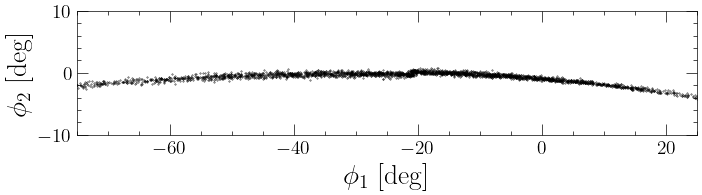

In [6]:
## Visualize the unperturbed stream
phi1_base, phi2_base = get_phi12_from_stream(stream_base[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

ax.scatter(phi1_base, phi2_base,s=.1,color='k',rasterized=True)

    

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-75,25)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

In [49]:
## import the impact generator, for generating parameters for subhalo impacts
from streamsculptor.GenerateImpactParams import ImpactGenerator

## We will generate 50 subhalo impacts
N_subhalos = 50

## The impact generator allows us to generate subhalo impact parameters
## We must specify the base potential, the observation time, 
## and the base stream (xyz, vxyz) coordinates and phi1 values at a bare minimum.
## We can also specify bounds for the parameters defining the impact.
## These bounds will set the range of the uniform distribution from which the parameters are drawn.
## For custom distributions, you can use other functions in the GenerateImpactParams module for more control.
ImpactGen = ImpactGenerator(pot=pot_base, tobs=0.0, stream=stream_base, 
                            stream_phi1=phi1_base, phi1_bounds=[-60,20],
                           tImpactBounds=[-2000,0.0],phi1window=.8,bImpact_bounds=[0,.1],
                           NumImpacts=N_subhalos, seednum=4942)



In [50]:
## Now we will ge the impact parameters.
## When running get_subhlo_ImpactParams, several backwards integrations are performed to
## determine the position and velocity of a subhalo approaching the stream at each time of impact.
ImpactParams = ImpactGen.get_subhalo_ImpactParams()

## The output is a dictionary, with cartesian coordinates of the impact and 
## coordinates in the more interpretable "impact frame" (e.g., bImpact, phi10 [the phi1 patch of the stream that was backwards integrated], etc.)
print(ImpactParams.keys())

dict_keys(['CartesianImpactParams', 'ImpactFrameParams'])


In [51]:
## CartesianImpactParams containts the cartesian impact parameters for each subhalo
ImpactParams['CartesianImpactParams'] # N x 6 array

Array([[-9.51549827e-01,  2.09490917e+01,  3.97292112e+00,
        -2.84700952e-02, -2.76741331e-01,  1.45717561e-01],
       [-1.52503120e+01, -1.29283015e+01,  6.36352504e+00,
        -2.10428893e-01,  2.59539570e-01, -3.65410274e-02],
       [-1.37306296e+01,  9.77876398e+00,  1.39097976e+01,
        -1.98405810e-02,  3.07365594e-02, -1.56538489e-02],
       [-9.89212171e+00, -7.63950725e+00,  6.49686778e+00,
         3.36257699e-01,  1.05887025e-02,  1.49419492e-01],
       [-1.19915135e+01,  1.04803533e+00,  6.81434043e+00,
         5.52666429e-02, -2.39755434e-01,  1.08167209e-01],
       [ 1.11261569e+01, -2.56373115e+00, -9.58814677e+00,
         2.27925431e-04, -2.25198821e-03, -1.56738347e-03],
       [ 1.03366425e+01,  1.01502789e+01, -2.23861176e+00,
         1.44817163e-01, -3.47525555e-02,  3.63621634e-01],
       [ 9.64231036e+00, -6.12967371e+00, -8.46122428e+00,
        -6.98456276e-02, -8.11026454e-02, -2.24722741e-02],
       [-1.51546858e+01, -3.54670821e+00,  9.929

In [52]:
## Dictionary specifying interpretable parameters of the impact
print(ImpactParams['ImpactFrameParams'].keys())

dict_keys(['bImpact', 'beta', 'gamma', 'phi', 'phi1_samples', 'tImpact', 'vImpact'])


Below we will specify the potential for the perturbations. We will treat the subhalos as Plummer potentials (default). It is straightforward to use other user-defined functional forms.

We must specify the mass (m), scale radius (a) for each of the subhalos in a 1D array (each element is a different subhalo).
We must also specify a position and velocity for the subhalo to define its "track" of motion. 

- The position coordinates `subhalo_x0` is a $N_{\rm sh} \times 3$ array, specifying the Cartesian location for each subhalo in the simulation frame at $t_{\rm impact}$ [Myr].
- The velocity coordinate `subhalo_v` is a $N_{\rm sh} \times 3$ array, specifying the Cartesian velocity for each subhalo in the simulation frame.
- `subhalo_t0` is the impact time, 1D array
- `t_window` is the time around $\pm$`subhalo_t0` for which the subhalo's potential is activated.

In [53]:
pot_pert = potential.SubhaloLinePotential(
                                        m=jnp.ones(N_subhalos), 
                                        a=jnp.ones(N_subhalos)*0.1,
                                        subhalo_x0=ImpactParams['CartesianImpactParams'][:,:3],
                                        subhalo_v=ImpactParams['CartesianImpactParams'][:,3:],
                                        subhalo_t0=ImpactParams['ImpactFrameParams']['tImpact'],
                                        t_window=100.0,
                                        units=usys
                                        )

pot_pert.potential(jnp.array([10,20.,30,]),-150.0)

Array(-6.09000635e-13, dtype=float64)

- We also need to specify _structural potentials_ for the subhalos. These potentials are only needed when computing radius perturbations in addition to mass perturbations. 

- The structural potential is simply the derivative of the subhalo potential (above) with respect to the scale-radius (in this case, `a` for the Plummer potential). We have implemented a convenience class to setup this potential for the Plummer sphere, but for more general potentials the structural potential can be computed using something like (pseudo-code):

```
@jax.jit
def phi(xyz,t,structural_param):
    compute stuff 
    .....
    .....
    .....
    return potential_value
    
@jax.jit
def phi_structural(xyz,t,structural_param):
    dphi_dstruct =  jax.grad(phi,argnums=(2,))
    return dphi_dstruct(xyz, t, structural_param)
```

- The subhalo mass in the potential below should be set to 1 [Msun], since we will rescale the mass linearly around this value.
    - Using another value for the mass (like a value, c) will not break anything, but when multiplying the derivatives by M you will really be multiplying by c*M. 
- The scale-radius is a user-defined choice. This is the _root_ scale radius that we will expand around. 
- Below we use 0.1 kpc. This can be adjusted/tuned to your particular use case. Though we will be perturbing around this expansion point.



In [54]:
pot_structural = potential.SubhaloLinePotential_dRadius(
                                          m=jnp.ones(N_subhalos), 
                                          a=jnp.ones(N_subhalos)*0.1,
                                          subhalo_x0=ImpactParams['CartesianImpactParams'][:,:3],
                                          subhalo_v=ImpactParams['CartesianImpactParams'][:,3:],
                                          subhalo_t0=ImpactParams['ImpactFrameParams']['tImpact'],
                                          t_window=100.0,
                                          units=usys
                                          )
pot_structural.potential(jnp.array([10,20.,30,]),-150.0)

Array(8.65723049e-17, dtype=float64)

Now that we have our potentials, we are almost ready to compute the derivatives we need. The final step before computing derivatives is to specify the base-stream model _without_ any subhalos. We have done all the work to set that up already. We only need to do some bookkeeping and specify parameters for the `BaseStreamModel` class. Streamsculptor will use the information from this class to compute the perturbation derivatives, since they are computed along the _unperturbed_ trajectory of each stream particle.

In [55]:
from streamsculptor.perturbative import BaseStreamModel
BaseModel = BaseStreamModel(
                potential_base=pot_base,
                prog_w0=prog_IC,
                ts=tstrip,
                Msat=1e4,
                seednum=483,
                solver=diffrax.Dopri5(),
                cpu=True)

In [56]:
from streamsculptor.perturbative import GenerateMassRadiusPerturbation
## Tell the impact generator 
## - the base potential 
## - the perturbing potential
## - the structural potential
## - the stream model that we are perturbing

## This function will compute derivatives of the stream-release function using automatic differentiation,
## and setup initial conditions for the perturbations.
Perturbation_Generator = GenerateMassRadiusPerturbation(
                                potential_base=pot_base,
                                potential_perturbation=pot_pert,
                                potential_structural=pot_structural,
                                BaseStreamModel=BaseModel,
                             )

Finally we will solve the equations of motion for the perturbed system
- OTF means "on-the-fly", since we will be computing the unperturbed stream and perturbations simultaneously (rather than using a precomputed stream)
- The solver is `Dopri8` (a 8th order adaptive time-step solver) with an absolute tolerance of 1e-9, relative tolerance of 1e-9, and minimum timestep of 0.01 Myr. 
- For 50 subhalos on cpu this takes a minute to run. Major speedup can be achieved using a gpu (recommended for >100 subhalos)
- If you are using a gpu, you can set `cpu = False`

In [57]:
result_lead, result_trail = Perturbation_Generator.compute_perturbation_OTF(cpu=True,
                                                                            solver=diffrax.Dopri8(),
                                                                            atol=1e-9,
                                                                            rtol=1e-9,
                                                                            dtmin=0.01)

Let's look at the structure of the output:

In [58]:
lead_base, trail_base = result_lead[0], result_trail[0]
lead_derivs, trail_derivs = result_lead[1], result_trail[1]

print('shape of base leading arm: ' + str(lead_base.shape))
print('shape of base trailing arm: ' + str(trail_base.shape))

print('shape of base leading arm derivs: ' + str(lead_derivs.shape))
print('shape of base trailing arm derivs: ' + str(trail_derivs.shape))


stream_base = jnp.vstack([lead_base, trail_base])
stream_derivs = jnp.vstack([lead_derivs, trail_derivs])



shape of base leading arm: (1499, 6)
shape of base trailing arm: (1499, 6)
shape of base leading arm derivs: (1499, 50, 12)
shape of base trailing arm derivs: (1499, 50, 12)


For a given arm of the stream (lead or trail), we a list of arrays. 
- The first array in the list (out[0]) is the unperturbed stream.
- The second array (out[1]) stores the derivatives for _each subhalo_ and _each particle_. 
- Because we have computed mass and radius derivatives, each stream particle and subhalo has an associated 12D vector:
    - `(dx/dM, dy/dM, dz/dM, dvx/dM, dvy/dM, dvz/dM, d2x/dMdrs, d2y/dMdrs, ..., d2vz/dMdrs)`

In [60]:
@jax.jit
def compute_pert_stream(stream_base, stream_derivs, mass_subhalos, delta_rs):
    """
    Helper function to compute the perturbed stream, once derivatives have already been calculated.
    stream_base: the base stream [N_particle x 6]
    stream_derivs: the derivatives of the stream [N_particle x N_subhalo x 12]
    mass_subhalos: the mass of each subhalo [N_subhalo]
    delta_rs: the radius perturbation for each subhalo [N_subhalo]

    outputs:
    stream_pert: the perturbed stream [N_particle x 6]
    """
    stream_response = stream_derivs[:,:,:6]*mass_subhalos[None,:,None] + stream_derivs[:,:,6:]*mass_subhalos[None,:,None]*delta_rs[None,:,None]
    ## Sum over the perturbations, add em all up
    stream_pert = stream_base + jnp.sum(stream_response,axis=1)
    return stream_pert


Below we will pick out one of the 50 subhalos, set the others to zero mass (so we have removed them from the simulation), and adjust the mass and radius of a single subhalo for illustration purposes.

We sample 10 different subhalo masses and radii (takes milliseconds at worst), plotting the output of each



In [110]:
import tqdm

In [182]:
mass_subhalos = jnp.zeros(N_subhalos)
delta_rs = jnp.ones(N_subhalos)*(-0.04)

test_mass = jnp.logspace(6,7.2,10)

pert_stream_list = []
for i in tqdm.tqdm(range(len(test_mass))):
    mass_subhalos = mass_subhalos.at[6].set(test_mass[i])
    stream_pert = compute_pert_stream(stream_base, stream_derivs,mass_subhalos,delta_rs)
    pert_stream_list.append(stream_pert)



100%|██████████| 10/10 [00:00<00:00, 1077.34it/s]


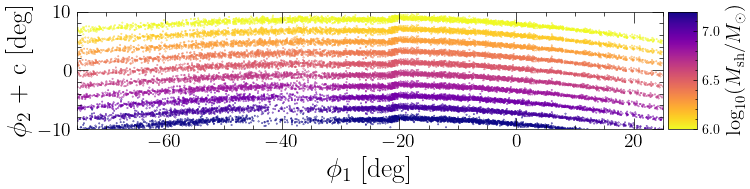

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

offset = 8.8

# Normalize log_mass values
norm = mcolors.Normalize(vmin=min(np.log10(test_mass)), vmax=max(np.log10(test_mass)))

for i in range(len(pert_stream_list)):
    phi1_p, phi2_p = get_phi12_from_stream(pert_stream_list[i][:,:3])
    mass = test_mass[i]
    log_mass = np.log10(mass)
    log_mass_array = np.full_like(phi1_p, log_mass) 
    sc = ax.scatter(phi1_p, phi2_p+offset, s=.1, c=log_mass_array, cmap='plasma_r', norm=norm, rasterized=True)
    offset += -1.9

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label(r'$\log_{10}(M_{\mathrm{sh}} / M_\odot)$', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-75,25)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ + c [deg]',fontsize=20)
ax.set_aspect('equal')

More massive subhalo --> larger gap

In [184]:
mass_subhalos = jnp.zeros(N_subhalos)
delta_rs = jnp.ones(N_subhalos)#*(-0.04)

test_rs = jnp.linspace(0.08,-0.08,10)

pert_stream_list_rs = []
for i in tqdm.tqdm(range(len(test_mass))):
    mass_subhalos = mass_subhalos.at[6].set(1e7)
    delta_rs = delta_rs.at[6].set(test_rs[i])
    stream_pert = compute_pert_stream(stream_base, stream_derivs,mass_subhalos,delta_rs)
    pert_stream_list_rs.append(stream_pert)



100%|██████████| 10/10 [00:00<00:00, 576.00it/s]


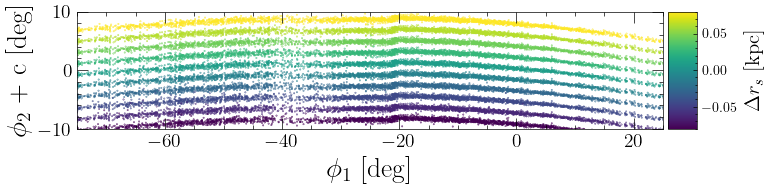

In [185]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

offset = 8.8

# Normalize log_mass values
norm = mcolors.Normalize(vmin=min(test_rs), vmax=max(test_rs))

for i in range(len(pert_stream_list_rs)):
    phi1_p, phi2_p = get_phi12_from_stream(pert_stream_list_rs[i][:,:3])
    delta_rs = test_rs[i]
    test_rs_array = np.full_like(phi1_p, delta_rs) 
    sc = ax.scatter(phi1_p, phi2_p+offset, s=.1, c=test_rs_array, cmap='viridis', norm=norm, rasterized=True)
    offset += -1.9

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label(r'$\Delta r_s$ [kpc]', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-75,25)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ + c [deg]',fontsize=20)
ax.set_aspect('equal')

Larger scale-radius @ fixed mass --> lower density --> less significant impact

Smaller scale-radius @ fixed mass --> higher density --> more significant gap